# Streaming

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

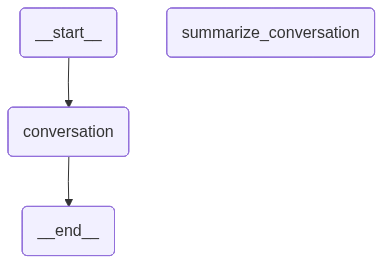

In [3]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming using updates

In [4]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hello my name is arnav")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Arnav! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CUgUWFwsRQxRCd7ag4hKGTY8oXwyu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--deec615b-b095-41b5-a947-009e38832200-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [5]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hello my name is arnav")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello Arnav! How are you today?


### Streaming using values

In [6]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hello my name is arnav")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hello my name is arnav
---------------------------------------------------------------------------
================================ Human Message =================================

hello my name is arnav
================================== Ai Message ==================================

Hello Arnav! How can I assist you today?
---------------------------------------------------------------------------


### Streaming tokens


In [7]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 1983 cricket world cup")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

In [8]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 1983 cricket world cup")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--674e0f8f-1ab1-4915-ba83-0677cfc64169')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--674e0f8f-1ab1-4915-ba83-0677cfc64169')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--674e0f8f-1ab1-4915-ba83-0677cfc64169')}
{'chunk': AIMessageChunk(content='198', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--674e0f8f-1ab1-4915-ba83-0677cfc64169')}
{'chunk': AIMessageChunk(content='3', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--674e0f8f-1ab1-4915-ba83-0677cfc64169')}
{'chunk': AIMessageChunk(content=' Cricket', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--674e0f8f-1ab1-4915-ba83-0677cfc64169')}
{'chunk': AIMessageChunk(conte

In [9]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 1983 cricket world cup")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| |198|3| Cricket| World| Cup|,| officially| known| as| the| Prud|ential| Cup|,| was| the| third| edition| of| the| Cricket| World| Cup|,| and| it| was| held| from| June| |9| to| June| |25|,| |198|3|,| in| England|.| This| tournament| is| particularly| memorable| because| it| marked| a| significant| turning| point| in| cricket| history|,| with| India| emerging| as| the| unexpected| champions|.

|Here| are| some| key| details| about| the| |198|3| Cricket| World| Cup|:

|1|.| **|Format|**|:| The| tournament| featured| eight| teams|:| India|,| England|,| Australia|,| West| Indies|,| Pakistan|,| Sri| Lanka|,| New| Zealand|,| and| Zimbabwe|.| The| format| was| a| round|-ro|bin| group| stage| followed| by| semi|-finals| and| a| final|.| Each| team| played| the| others| in| their| group| once|,| and| the| top| two| teams| from| each| group| advanced| to| the| semi|-finals|.

|2|.| **|Groups|**|:| The| teams| were| divided| into| two| groups|:
|  | -| Group| A|:| England|,| Pakistan|,| New

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage
config = {"configurable": {"thread_id": "7"}}

# This input has 7 messages, which will trigger the `should_continue`to return "summarize_conversation"
long_input = [
    HumanMessage(content="Hi im arnav"),
    AIMessage(content="Hello how may i help you"),
    HumanMessage(content="i would like to know which companies are included in MAANG"),
    AIMessage(content="Meta, Apple, Amazon, Netflix, and Google are companies included in MAANG"),
    HumanMessage(content="What's my name again?"),
    AIMessage(content="Your told your name is arnav"),
    HumanMessage(content="And which companiesa are inluded in MAANG?"),
]

print("Streaming summary tokens for summarization_nodes:")

async for event in graph.astream_events({"messages": long_input}, config, version="v2"):

    
    if (
        event["event"] == "on_chat_model_stream" 
        and event['metadata'].get('langgraph_node','') == "summarize_conversation"
    ):
        data = event["data"]
        print(data["chunk"].content, end="|")


Streaming summary tokens for summarization_nodes:
|In| the| conversation|,| Ar|nav| introduces| himself| and| asks| about| the| companies| included| in| MA|ANG|.| The| response| provided| lists| the| companies| as| Meta|,| Apple|,| Amazon|,| Netflix|,| and| Google|.| Ar|nav| then| asks| for| a| reminder| of| his| name|,| which| is| confirmed| as| Ar|nav|.| Finally|,| he| asks| again| about| the| companies| in| MA|ANG|,| and| the| same| list| is| provided|.||||